In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

## Define utility functions

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_1d_error_frac(cov, fid_vals, names, inds: list, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    #verify that names and inds are of the same length
    assert len(names)==len(inds)

    ax.barh(names, np.sqrt(cov[inds, inds])/np.abs(fid_vals), **kwargs)

def plot_1d_error(cov, names, inds: list, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    #verify that names and inds are of the same length
    assert len(names)==len(inds)

    ax.barh(names, np.sqrt(cov[inds, inds]), **kwargs)

def plot_contours(cov, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])
        
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstds[0] * np.sqrt(vals[0]),
                     height=2.0 * nstds[0] * np.sqrt(vals[1]), angle=theta, alpha=0.8,**kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstds[1] * np.sqrt(vals[0]),
                     height=2.0 * nstds[1] * np.sqrt(vals[1]), angle=theta, alpha=0.2,**kwargs)
    ellips=[ellip1,ellip2]

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(cov, pos, ind, cl=0.9545, ax=None, print_mu_sigma = True, **kwargs):
  mu = pos[ind]
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  x_1sigma = np.linspace(mu-sigma, mu+sigma, num=num, endpoint=True)
  x_2sigma = np.linspace(mu-2*sigma, mu+2*sigma, num=num, endpoint=True)
  
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.fill_between(x_1sigma, np.exp(-.5*((x_1sigma-mu)/sigma)**2), alpha=.8, **kwargs)
  ax.fill_between(x_2sigma, np.exp(-.5*((x_2sigma-mu)/sigma)**2), alpha=.2, **kwargs)
  ax.set_xlim((x[0], x[-1]))
  
  if print_mu_sigma:
    textstr=textstr = '\n'.join((
        r'$\mu=%f.4$' % (mu, ),
        r'$\sigma=%f.4$' % (sigma, )))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
  
  return (mu, sigma)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
cosmo_param_nr = 1
param_nr = cosmo_param_nr+1
use_hs = True #Plot hs instead of H0s.

PL18_h=0.6732
PL18_omegac=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2)
PL18_sigma8=0.812
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma0=0.55
GR_gamma1=0.


fid_cosmo = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa,
                         gamma0=GR_gamma0, gamma1=GR_gamma1)
fid_H0s = fid_cosmo.h*100*jc.transfer.sh_d_AAN(fid_cosmo)
print(jc.transfer.sh_d_AAN(fid_cosmo))
if use_hs:
    fid_H0s = fid_H0s/100

99.00314626836801


## Define functions for getting the parameter vectors for BAO

In [4]:
def get_params_vec_BAO(cosmo, H0s):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, gamma, w0, wa] 
        #cosmo.Omega_k,
        cosmo.Omega_m,# cosmo.Omega_b,
        #cosmo.w0, cosmo.wa,
        H0s
    ])

def unpack_params_vec_BAO(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    H0s = params[cosmo_param_nr]
    return cosmo, H0s

In [5]:
from jax_cosmo.background import growth_rate, growth_factor
from jax_cosmo.utils import z2a

def DA_s(cosmo, H0s, z):
    a = z2a(z) 
    d_A = jc.background.radial_comoving_distance(cosmo, a) #Get d_A (=chi for omega_k=0) from Jax Cosmo
    radial_distance = d_A*(cosmo.h*100) #Remove factor of 1/H0 from chi so we can add it back in with 1/(H0s)
    d_A_s = (1/H0s)*(1/(1+z))*radial_distance #Compute d_A/s
    return d_A_s

def Hs(cosmo, H0s, z):
    a = z2a(z)
    E = np.sqrt(jc.background.Esqr(cosmo,a))
    Hs = H0s*E
    if use_hs:
        Hs = Hs/100
    return Hs

In [6]:
def compute_BAO_mean(params, z):
    cosmo_params, H0s = unpack_params_vec_BAO(params)
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-PL18_omegab,
                         #Omega_m = PL18_omegac+PL18_omegab,
                         #Omega_c = PL18_omegac,
                         Omega_b=PL18_omegab,
                         Omega_k=PL18_omegak,
                         h=PL18_h,
                         n_s=PL18_ns,
                         #S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**.5, sigma8=PL18_sigma8,
                         S8=PL18_sigma8*(cosmo_params[0]/0.3)**.5, sigma8=PL18_sigma8,
                         #w0=cosmo_params[1], wa = cosmo_params[2],
                         w0 = PL18_w0, wa=PL18_wa,
                         gamma0=GR_gamma0, gamma1=GR_gamma1)
    DA_s_data = DA_s(cosmo, H0s, z)
    Hs_data = Hs(cosmo, H0s, z)
    BAOs = np.concatenate((DA_s_data, Hs_data)) #Assumes z is given as an array
    return BAOs

In [7]:
fid_params = get_params_vec_BAO(fid_cosmo, fid_H0s)

In [8]:
compute_BAO_jac = jax.jit(jax.jacfwd(compute_BAO_mean))

### DESI observed variances

In [9]:
DESI_BAO_z = np.linspace(.65,1.85,num=13, endpoint=True)
DESI_Da_s_err_pct = np.array([.82,.69,.69,.73,.89,.94,.96,1.5,
                         1.59,1.9,2.88,4.64,4.71])
DESI_Hs_err_pct = np.array([1.5, 1.27, 1.22, 1.22, 1.37, 1.39, 1.39,
                            2.02, 2.13, 2.52, 3.80, 6.30, 6.39])

print(DESI_Hs_err_pct.shape)
print(DESI_Da_s_err_pct.shape)

DESI_BAO_err_pct = np.concatenate((DESI_Da_s_err_pct, DESI_Hs_err_pct))

DESI_BAO_err_frac = DESI_BAO_err_pct/100

means = compute_BAO_mean(fid_params, z=DESI_BAO_z)
jacobian = compute_BAO_jac(fid_params, z=DESI_BAO_z)
print(jacobian)

(13,)
(13,)


[[-4.26148321e+02 -1.50719854e+01]
 [-5.03295570e+02 -1.59490462e+01]
 [-5.74880450e+02 -1.66342036e+01]
 [-6.40306964e+02 -1.71635264e+01]
 [-6.99327595e+02 -1.75653500e+01]
 [-7.51957111e+02 -1.78622444e+01]
 [-7.98525649e+02 -1.80731575e+01]
 [-8.39790989e+02 -1.82155331e+01]
 [-8.75559488e+02 -1.82979326e+01]
 [-9.06900870e+02 -1.83343126e+01]
 [-9.33689925e+02 -1.83294660e+01]
 [-9.56930880e+02 -1.82939739e+01]
 [-9.76603408e+02 -1.82308706e+01]
 [ 8.03437397e-01  1.44844112e-02]
 [ 9.43523578e-01  1.53969458e-02]
 [ 1.08605341e+00  1.63595563e-02]
 [ 1.23074418e+00  1.73693480e-02]
 [ 1.37741148e+00  1.84236828e-02]
 [ 1.52594177e+00  1.95201754e-02]
 [ 1.67627119e+00  2.06566789e-02]
 [ 1.82836954e+00  2.18312652e-02]
 [ 1.98222878e+00  2.30422041e-02]
 [ 2.13785464e+00  2.42879419e-02]
 [ 2.29526092e+00  2.55670813e-02]
 [ 2.45446552e+00  2.68783630e-02]
 [ 2.61548774e+00  2.82206487e-02]]


In [10]:
cov_mat = np.diag((DESI_BAO_err_frac*means)**2)
prc_mat = np.linalg.inv(cov_mat)

In [11]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)
print(fisher)
print(np.linalg.inv(fisher))

(2, 2)
[[9.62415112e+04 1.80582950e+03]
 [1.80582950e+03 3.84750133e+01]]
[[ 8.70725092e-05 -4.08675896e-03]
 [-4.08675896e-03  2.17803430e-01]]


(2, 2)
[[9.62415112e+04 1.80582950e+03]
 [1.80582950e+03 3.84750133e+01]]
[[ 8.70725092e-05 -4.08675896e-03]
 [-4.08675896e-03  2.17803430e-01]]


Text(0.5, 1.0, '1-$\\sigma$ error magnitudes from BAO')

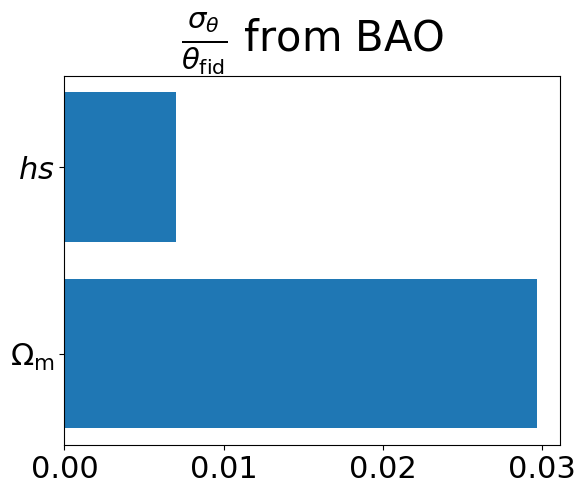

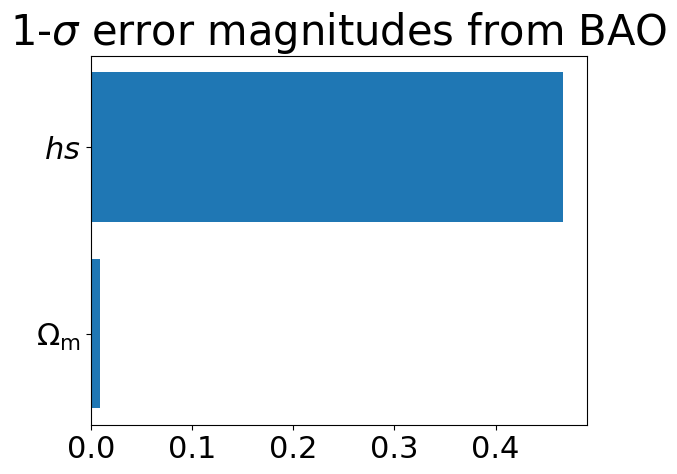

In [12]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)
print(fisher)
print(np.linalg.inv(fisher))
fisher_inv = np.linalg.inv(fisher)
extract_params = param_nr

if use_hs:
    param_names = (r'$\Omega_\mathrm{m}$',# r'$\Omega_\mathrm{b}$',
               #r'$w_0$', r'$w_a$',
               r'$hs$'
               )
else:
    param_names = (r'$\Omega_\mathrm{m}$',# r'$\Omega_\mathrm{b}$',
               #r'$w_0$', r'$w_a$',
                r'$H_0s$'
               )

fig,ax = plt.subplots(1,1)

plot_1d_error_frac(fisher_inv, fid_params, param_names, np.arange(param_nr), ax)
    
ax.set_title(r'$\frac{\sigma_\theta}{\theta_\mathrm{fid}}$ from BAO', fontsize=30)


fig,ax = plt.subplots(1,1)
plot_1d_error(fisher_inv, param_names, np.arange(param_nr), ax)
ax.set_title(r'1-$\sigma$ error magnitudes from BAO', fontsize=30)

Text(0.5, 0.98, 'BAO')

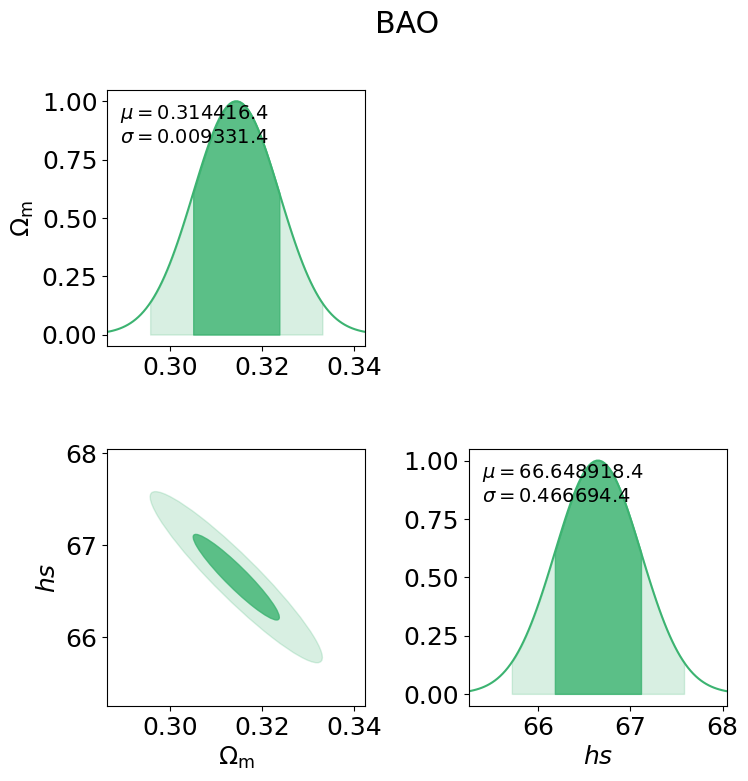

In [13]:
plt.rcParams.update({'font.size' : 18})

fig= plt.figure(figsize=(extract_params*4,extract_params*4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            mu, sigma = plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
            #print(param_names[i], r'1-$\sigma$ range$', mu, r'$\pm$', sigma)
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('BAO')